# Water and Income

Among the many environmental challenges that the world faces, one of the most significant is water. Essential to all forms of life and in many industrial processes, in many areas of the world water is scarce and valuable. Worse, many sources of water are either slow to regenerate compared to human demands, are threatened by climate change or other environmental changes, or require expensive and complex infrastructure to extract and use. Therefore, a better understanding of water demand and water usage is essential to ensuring the continuing well-being of people around the world and the economic stability and viability of many countries.

In this work, I aim to understand the relationship between per-capita water usage and per-capita income in a range of countries around the world, using the World Bank's World Development Indicators dataset. My goal, in particular, is to understand the correlation or relationship between per-capita water usage and per-capita income--does water usage increase with income? Or maybe it decreases? Or perhaps it increases up to a point and then decreases? My expectation is that this last scenario is correct--that is, that at very low per-capita income levels water usage is low, due to the lack of water supply and sewage infrastructure, at moderate per-capita income levels it is high due to the construction of such infrastructure and resulting increases in demand for water-consuming services, and at high per-capita income levels it is lower (but still much higher than at low incomes) due to saturation of demand for water-consuming services and a resulting focus on efficiency in water supply and consumption over expanded usage.

While this analysis cannot resolve whether these proposed explanations for the trend are correct, it can resolve whether the trend itself exists, and determining that is what I am setting out to do in this project.

In [1]:
# Begin by importing critical libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

The World Development Indicators dataset, found at https://www.kaggle.com/kaggle/world-development-indicators, is a highly complex dataset split into several portions. Most of the datafiles provided in the dataset are explanatory files that have descriptions of the various country codes used, information about the indicator codes used to describe different observations, and other information. The actual indicators are stored in the file indicators.csv, which is the only one that I will actually load in this notebook; for the others I will incorporate any information relevant to this analysis (for example, which codes are important for the anlaysis) into this notebook's explanatory text on an as-needed basis.

In [2]:
# Edit this to point towards your copy of the dataset
raw_indicators = pd.read_csv('../data/raw/Indicators.csv')

raw_indicators.head()

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
0,Arab World,ARB,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1960,1.335609e+02
1,Arab World,ARB,Age dependency ratio (% of working-age populat...,SP.POP.DPND,1960,8.779760e+01
2,Arab World,ARB,"Age dependency ratio, old (% of working-age po...",SP.POP.DPND.OL,1960,6.634579e+00
3,Arab World,ARB,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,1960,8.102333e+01
4,Arab World,ARB,Arms exports (SIPRI trend indicator values),MS.MIL.XPRT.KD,1960,3.000000e+06


In [3]:
raw_indicators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5656458 entries, 0 to 5656457
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   CountryName    object 
 1   CountryCode    object 
 2   IndicatorName  object 
 3   IndicatorCode  object 
 4   Year           int64  
 5   Value          float64
dtypes: float64(1), int64(1), object(4)
memory usage: 258.9+ MB


A brief perusal shows that this is a rather large file with much information that isn't relevant to the analysis. The relevant indicators for this analysis are ER.H2O.FWTL.K3, measuring annual freshwater withdrawals (thus consumption) in billions of cubic meters (or cubic kilometers); SL.GDP.PCAP.EM.KD, GDP per person employed in 1990 dollars; SI.SPR.PCAP, survey mean-consumption per capita in 2011 dollars per day; and SP.POP.TOTL, the total population. The Series file provides cautions about the reliability and comparability of most of these indicators, however as there are no alternatives I will forge ahead regardless. Nevertheless, this analysis should be taken as preliminary at best and only reliable insofar as it can definitively rule out the relationship between income and water consumption proposed above.

Since I do not care about the other rows in the dataframe, I will create a reduced dataframe that only has the data of interest for this analysis. This will require much less memory and simplify further work.

In [4]:
analysis_codes = ['ER.H2O.FWTL.K3', 'SL.GDP.PCAP.EM.KD', 'SI.SPR.PCAP', 'SP.POP.TOTL']

reduced_indicators = raw_indicators[raw_indicators['IndicatorCode'].isin(analysis_codes)]

reduced_indicators.head()

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
73,Arab World,ARB,"Population, total",SP.POP.TOTL,1960,9.249590e+07
150,Caribbean small states,CSS,"Population, total",SP.POP.TOTL,1960,4.190810e+06
221,Central Europe and the Baltics,CEB,"Population, total",SP.POP.TOTL,1960,9.140158e+07
341,East Asia & Pacific (all income levels),EAS,"Population, total",SP.POP.TOTL,1960,1.042475e+09
462,East Asia & Pacific (developing only),EAP,"Population, total",SP.POP.TOTL,1960,8.964930e+08


In [5]:
reduced_indicators.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19265 entries, 73 to 5641524
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CountryName    19265 non-null  object 
 1   CountryCode    19265 non-null  object 
 2   IndicatorName  19265 non-null  object 
 3   IndicatorCode  19265 non-null  object 
 4   Year           19265 non-null  int64  
 5   Value          19265 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 1.0+ MB


While this succeeded in greatly reducing the number of rows and memory usage, as well as discarding much information of no relevance, the structure of this dataset is still not ideal for analysis. The most obvious issue, which can be seen just from looking at the rows printed above, is that many of the "countries" listed in the dataset are actually multinational regions such as the "Arab World" or "East Asia and Pacific". While potentially interesting to analyze regions as well as individual countries, these should clearly not be lumped together, at least not without care. A more subtle issue is that the data itself is stored in a messy and complex form that is difficult to use easily, with each row identifying a unique combination of country, year, and indicator. A more useful form would be for each row to identify a unique country and year, with the indicators instead being stored in individual columns. Finally, the columns "CountryName" and "IndicatorName" are redundant, as the values can be looked up outside of the dataframe (and in the case of "IndicatorName" have only a limited number of possible values anyway).

Therefore, the next step is to tidy up this dataset. Dropping the redundant columns is easy and should come first:

In [6]:
reduced_indicators = reduced_indicators.drop(columns=['CountryName', 'IndicatorName'])

reduced_indicators.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19265 entries, 73 to 5641524
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CountryCode    19265 non-null  object 
 1   IndicatorCode  19265 non-null  object 
 2   Year           19265 non-null  int64  
 3   Value          19265 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 752.5+ KB


Next, the dataframe should be restructured so that each row represents a unique combination of year and country code, with the indicator values separated into one column per variable. This is most easily done by splitting the dataset into several dataframes, one per variable, then joining them back together using Pandas' built-in SQL-like methods:

In [7]:
water_dataset = reduced_indicators[reduced_indicators['IndicatorCode'] == 'ER.H2O.FWTL.K3']
per_capita_gdp_dataset = reduced_indicators[reduced_indicators['IndicatorCode'] == 'SL.GDP.PCAP.EM.KD']
per_capita_consumption_dataset = reduced_indicators[reduced_indicators['IndicatorCode'] == 'SI.SPR.PCAP']
population_dataset = reduced_indicators[reduced_indicators['IndicatorCode'] == 'SP.POP.TOTL']

water_gdp = water_dataset.merge(per_capita_gdp_dataset, on=['CountryCode', 'Year'], how='outer')
water_gdp = water_gdp.rename(columns={'Value_x': 'freshwater_withdrawals_k3', 'Value_y': 'per_employed_gdp_ppp_1990$'})

consumption_population = per_capita_consumption_dataset.merge(population_dataset, on=['CountryCode', 'Year'], how='outer')
consumption_population = consumption_population.rename(columns={'Value_x': 'per_capita_consumption_2011$', 'Value_y': 'total_population'})

wide_indicators = water_gdp.merge(consumption_population, on=['CountryCode', 'Year'], how='outer')
wide_indicators.head()

,CountryCode,IndicatorCode_x_x,Year,freshwater_withdrawals_k3,IndicatorCode_y_x,per_employed_gdp_ppp_1990$,IndicatorCode_x_y,per_capita_consumption_2011$,IndicatorCode_y_y,total_population
0,BRB,ER.H2O.FWTL.K3,1962,0.030,NaN,NaN,NaN,NaN,SP.POP.TOTL,232584.0
1,URY,ER.H2O.FWTL.K3,1967,0.650,NaN,NaN,NaN,NaN,SP.POP.TOTL,2750093.0
2,DZA,ER.H2O.FWTL.K3,1972,2.000,NaN,NaN,NaN,NaN,SP.POP.TOTL,15377095.0
3,GHA,ER.H2O.FWTL.K3,1972,0.300,NaN,NaN,NaN,NaN,SP.POP.TOTL,9083575.0
4,ISR,ER.H2O.FWTL.K3,1972,1.564,NaN,NaN,NaN,NaN,SP.POP.TOTL,3148000.0


There is now no use to keeping the IndicatorCode variables around, so those columns can additionally be dropped. Additionally, it would be more helpful to have the units of freshwater withdrawals in cubic meters than cubic kilometers, as this is more closely scaled to individual consumption levels:

In [8]:
wide_indicators = wide_indicators.drop(columns=['IndicatorCode_x_x', 'IndicatorCode_y_x', 'IndicatorCode_x_y', 'IndicatorCode_y_y'])

wide_indicators['freshwater_withdrawals_k3'] = wide_indicators['freshwater_withdrawals_k3'] * 1e9 # 1 km3 = 1e9 m3
wide_indicators = wide_indicators.rename(columns={'freshwater_withdrawals_k3': 'freshwater_withdrawals_m3'})

wide_indicators.head()

,CountryCode,Year,freshwater_withdrawals_m3,per_employed_gdp_ppp_1990$,per_capita_consumption_2011$,total_population
0,BRB,1962,3.000000e+07,NaN,NaN,232584.0
1,URY,1967,6.500000e+08,NaN,NaN,2750093.0
2,DZA,1972,2.000000e+09,NaN,NaN,15377095.0
3,GHA,1972,3.000000e+08,NaN,NaN,9083575.0
4,ISR,1972,1.564000e+09,NaN,NaN,3148000.0


It is obvious from the above that there are a number of country-year pairs that lack some part of the data of interest, which may mean that only a limited subset of country-year pairs are actually suitable for analysis. A few quick statistics on the rows with no null values for each variable may help clarify this.

In [9]:
wide_indicators.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13487 entries, 0 to 13486
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   CountryCode                   13487 non-null  object 
 1   Year                          13487 non-null  int64  
 2   freshwater_withdrawals_m3     732 non-null    float64
 3   per_employed_gdp_ppp_1990$    4881 non-null   float64
 4   per_capita_consumption_2011$  168 non-null    float64
 5   total_population              13484 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 737.6+ KB


In [10]:
print(wide_indicators[wide_indicators['freshwater_withdrawals_m3'].notna()]['Year'].value_counts().sort_index())

1962      1
1967      1
1972      7
1977     20
1982     36
1987     62
1992     60
1997     64
2002    134
2007     99
2012     36
2013    212
Name: Year, dtype: int64


In [11]:
print(wide_indicators[wide_indicators['per_employed_gdp_ppp_1990$'].notna()]['Year'].value_counts().sort_index())

1980    118
1981    118
1982    118
1983    118
1984    118
1985    119
1986    119
1987    119
1988    119
1989    119
1990    120
1991    149
1992    149
1993    149
1994    149
1995    149
1996    149
1997    149
1998    149
1999    149
2000    149
2001    149
2002    149
2003    149
2004    149
2005    149
2006    149
2007    149
2008    149
2009    149
2010    149
2011    149
2012    149
2013    149
2014    149
Name: Year, dtype: int64


In [12]:
print(wide_indicators[wide_indicators['per_capita_consumption_2011$'].notna()]['Year'].value_counts().sort_index())

2003     2
2004     7
2005     5
2006    10
2007    42
2008    13
2009     5
2010    11
2011    11
2012    51
2013     9
2014     2
Name: Year, dtype: int64


In [13]:
print(wide_indicators[wide_indicators['total_population'].notna()]['Year'].value_counts().sort_index())

1960    244
1961    244
1962    244
1963    244
1964    244
1965    244
1966    244
1967    244
1968    244
1969    244
1970    244
1971    244
1972    244
1973    244
1974    244
1975    244
1976    244
1977    244
1978    244
1979    244
1980    244
1981    244
1982    244
1983    244
1984    244
1985    244
1986    244
1987    244
1988    244
1989    244
1990    246
1991    246
1992    245
1993    245
1994    245
1995    246
1996    246
1997    246
1998    247
1999    247
2000    247
2001    247
2002    247
2003    247
2004    247
2005    247
2006    247
2007    247
2008    247
2009    247
2010    247
2011    247
2012    247
2013    247
2014    247
Name: Year, dtype: int64


Given the above, it seems that, first, the survey-based consumption statistics are not available in enough countries in enough years to be worth using; the per-capita GDP numbers are much more useful because they are more available. Second, only in 2002 and 2013 does it apepar that a large fraction of entities with per-capita GDP data also have water consumption data, therefore only these two dates are feasible for analysis. Thus, a bit more cleaning is needed to get rid of the consumption statistics, since those aren't useful, and to eliminate data for years other than 2002 and 2013. Additionally, even in the case of those years rows with null data in any of the three remaining variable columns should be dropped, as no useful analysis can be carried out on them. Finally, the CountryCode and Year columns should be renamed as well, to have the same format as the other columns.

In [14]:
wide_indicators = wide_indicators.drop(columns=['per_capita_consumption_2011$'])
wide_indicators = wide_indicators[(wide_indicators['Year'] == 2002) | (wide_indicators['Year'] == 2013)]
wide_indicators = wide_indicators.dropna(how='any', axis=0)
wide_indicators = wide_indicators.rename(columns={'CountryCode': 'country', 'Year': 'year'})

print(wide_indicators.info())

print(wide_indicators[wide_indicators['year'] == 2002].info())
print(wide_indicators[wide_indicators['year'] == 2013].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239 entries, 252 to 731
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   country                     239 non-null    object 
 1   year                        239 non-null    int64  
 2   freshwater_withdrawals_m3   239 non-null    float64
 3   per_employed_gdp_ppp_1990$  239 non-null    float64
 4   total_population            239 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 11.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 91 entries, 252 to 384
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   country                     91 non-null     object 
 1   year                        91 non-null     int64  
 2   freshwater_withdrawals_m3   91 non-null     float64
 3   per_employed_gdp_ppp_1990$  91 n

As I indicated at the beginning, what I am interested in is comparing the per-capita usage of water and the per-capita GDP. While the latter (or at least a reasonable approximation) is already present in the dataset, the former is merely implicit in having freshwater withdrawals and population for each country. Adding a column containing this information directly would make further analysis easier.

In [15]:
wide_indicators['per_capita_water_m3'] = wide_indicators['freshwater_withdrawals_m3'] / wide_indicators['total_population']

print(wide_indicators.head())

    country  year  freshwater_withdrawals_m3  per_employed_gdp_ppp_1990$  \
252     ALB  2002               1.838000e+09                     11456.0   
253     DZA  2002               5.723000e+09                     13925.0   
254     AGO  2002               6.405000e+08                      2386.0   
256     ARM  2002               1.733000e+09                     14758.0   
257     AUS  2002               2.258000e+10                     48565.0   

     total_population  per_capita_water_m3  
252         3051010.0           602.423460  
253        31990387.0           178.897492  
254        16109696.0            39.758665  
256         3047249.0           568.709679  
257        19651400.0          1149.027550  


A final issue, as mentioned previously, is that some of the "countries" included in both datasets, especially the 2013 dataset, are not really countries at all, but rather multinational conglomerations. For example, there are country codes for "the Arab World" (ARB) and "Euro area" (EMU). While analyzing these might also be interesting, they are clearly different from the other countries and ought to be separated from data on individual countries. The actual regional codes are:
* ARB, the Arab World;
* CSS, Caribbean small states;
* CEB, Central Europe and the Baltics;
* EAS, East Asia and Pacific (all incomes);
* EAP, East Asia and Pacific (developing only);
* EMU, Euro are;
* ECS, Europe and Central Asia (all incomes);
* ECA, Europe and Central Asia (developing only);
* EUU, European Union;
* FCS, Fragile and conflict-afflicted situations;
* HPC, Heavily-indebted poor countries;
* HIC, High-income countries;
* NOC, High-income non-OECD countries;
* OEC, High-income OECD countries;
* LCN, Latin America and Caribbean (all incomes);
* LAC, Latin America and Caribbean (developing only);
* LDC, Least developed countries;
* LMY, Low and middle income;
* LIC, Low-income countries;
* LMC, Lower-middle income countries;
* MEA, Middle East and North Africa (all incomes);
* MNA, Middle East and North Africa (developing only);
* MIC, Middle-income countries;
* NAC, North America;
* OED, OECD members;
* OSS, Other small states;
* PSS, Pacific island small states;
* SAS, South Asia;
* SSF, Sub-Saharan Africa (all incomes);
* SSA, Sub-Saharan Africa (developing only);
* UMC, Upper-middle income countries; and
* WLD, the world as a whole.

In [16]:
non_country_codes = ["ARB", "CSS", "CEB", "EAS", "EAS", "EAP", "EMU", "ECS", "ECA", "EUU", "FCS", "HPC", "HIC", "NOC", "OEC", "LCN", "LAC", "LDC", "LMY", "LIC", "LMC", "MEA", "MNA", "MIC", "NAC", "OED", "OSS", "PSS", 'SAS', "SSF", "SSA", "UMC", "WLD"]

supranational_indicators = wide_indicators[wide_indicators['country'].isin(non_country_codes)]
national_indicators = wide_indicators[-wide_indicators['country'].isin(non_country_codes)]

In [17]:
print(supranational_indicators.info())
print(national_indicators.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28 entries, 520 to 551
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   country                     28 non-null     object 
 1   year                        28 non-null     int64  
 2   freshwater_withdrawals_m3   28 non-null     float64
 3   per_employed_gdp_ppp_1990$  28 non-null     float64
 4   total_population            28 non-null     float64
 5   per_capita_water_m3         28 non-null     float64
dtypes: float64(4), int64(1), object(1)
memory usage: 1.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 211 entries, 252 to 731
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   country                     211 non-null    object 
 1   year                        211 non-null    int64  
 2   freshwater_withdrawals_m3   211 n

Now that the data has been cleaned and the per-capita water usage has been calculated, the actual analysis is straightforward. I only need to plot per-capita water usage versus GDP per employed person to see if the relationship I proposed holds true or not:

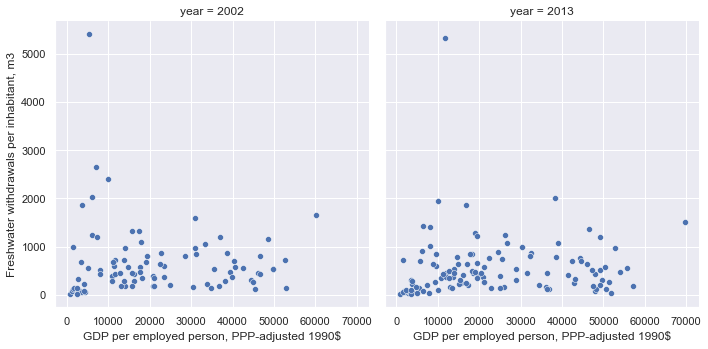

In [18]:
sns.set_theme()

plot = sns.relplot(data=national_indicators, x='per_employed_gdp_ppp_1990$', y='per_capita_water_m3', col='year')
plot.set_xlabels('GDP per employed person, PPP-adjusted 1990$')
plot.set_ylabels('Freshwater withdrawals per inhabitant, m3')
plt.show()

This shows some weak evidence for my hypothesis; there does appear to be a *slight* bell shape, particularly with 2013. However, this relationship is obviously quite weak, and there are a number of clear exceptions. In particular, there are a number of countries with low GDPs per employed person with high water withdrawals, especially in 2002. It might be worth looking at these countries more closely:

In [19]:
high_withdrawals_low_GDP = national_indicators[(national_indicators['per_employed_gdp_ppp_1990$'] < 15000)
                                               & (national_indicators['per_capita_water_m3'] > 1500)]

print(high_withdrawals_low_GDP[['country', 'year', 'per_employed_gdp_ppp_1990$', 'per_capita_water_m3']])

    country  year  per_employed_gdp_ppp_1990$  per_capita_water_m3
309     IRQ  2002                      6959.0          2645.948834
316     KGZ  2002                      5983.0          2019.756748
367     TJK  2002                      3736.0          1866.848731
373     TKM  2002                      5425.0          5415.014917
379     UZB  2002                      9951.0          2397.133570
628     IRQ  2013                     10093.0          1953.738723
718     TKM  2013                     11834.0          5333.879889


Only five countries fit into this group: Iraq (IRQ), Kyrgyzstan (KGZ), Tajikistan (TJK), Turkmenistan (TKM), and Uzbekistan (UZB). Except for Iraq, all of these countries are located in Central Asia, where the Soviet Union built large irrigation projects in the 1960s and 1970s to grow cash crops such as cotton. These projects have diverted so much of the flow of the Amu Darya and Syr Darya rivers that the Aral Sea, formerly one of the largest lakes in the world, has almost entirely dried up. This background helps explain the disparity with my hypothesis, since the Soviet Union as a whole was relatively richer than the Central Asian republics, and could therefore afford to build costlier and more extensive water diversion infrastructure than those republics could on their own. Something similar may hold true in the case of Iraq, where oil profits in the 1970s or 1980s might have enabled the construction of extensive water infrastructure, whereas the sanctions of the 1990s and the civil war of the 2000s led to declines in GDP.

Besides these outliers, another outlier that stands out to me is the one country with an unusually high GDP, $60 000 or more, and moderately high water consumption, about 1500-2000 cubic meters per person.

In [20]:
rich_outlier = national_indicators[(national_indicators['per_employed_gdp_ppp_1990$'] > 55000)
                                               & (national_indicators['per_capita_water_m3'] > 1500)]

print(rich_outlier[['country', 'year', 'per_employed_gdp_ppp_1990$', 'per_capita_water_m3', 'freshwater_withdrawals_m3']])

    country  year  per_employed_gdp_ppp_1990$  per_capita_water_m3  \
377     USA  2002                     60200.0          1645.891986   
723     USA  2013                     69643.0          1511.544177   

     freshwater_withdrawals_m3  
377               4.734000e+11  
723               4.784000e+11  


Not entirely surprisingly, this turns out to be the United States, which is consistently one of the richest countries in the world in terms of per-capita GDP and which does have a considerable amount of water-hungry agriculture in the Great Plains and Southwest that probably accounts for its high water consumption levels.

A final outlier of interest is the one with a moderate GDP (of about $30-40 000) and relatively high water withdrawals, similar to those of the United States:

In [21]:
middle_income_outlier = national_indicators[(national_indicators['per_employed_gdp_ppp_1990$'] > 30000)
                                               & (national_indicators['per_capita_water_m3'] > 1500)]

print(middle_income_outlier[['country', 'year', 'per_employed_gdp_ppp_1990$', 'per_capita_water_m3']])

    country  year  per_employed_gdp_ppp_1990$  per_capita_water_m3
273     CHL  2002                     30823.0          1586.407690
377     USA  2002                     60200.0          1645.891986
584     CHL  2013                     38207.0          2015.836177
723     USA  2013                     69643.0          1511.544177


This seems to be Chile, which surprises me. Perhaps this is related to Chile's control of both extensive deserts in its north and large well-watered areas in the south, but unlike with Central Asia or the United States there is no obvious explanation that I can see.

An additional interesting analysis might be to include regional information in the previous plots, to see at a quick glance whether there might be some kind of regional patterns (such as the Central Asian nations having unusually high water usage). Using the United Nations Statistical Division's geoscheme,

In [22]:
north_america = ['USA', 'CAN', 'BMU', 'GRL']
central_america = ['BLZ', 'CRI', 'SLV', 'GTM', 'HND', 'MEX', 'NIC', 'PAN']
caribbean = ['ATG', 'ABW', 'BHS', 'BRB', 'VIR', 'CYM', 'CUB', 'CUW', 'DMA', 'DOM', 'GRD', 'HTI',
             'JAM', 'PRI', 'KNA', 'LCA', 'MAF', 'VCT', 'SXM', 'VCT', 'TTO', 'TCA']
south_america = ['ARG', 'BOL', 'BRA', 'CHL', 'COL', 'ECU', 'GUY', 'PRY', 'PER', 'SUR', 'URY', 'VEN']

north_africa = ['DZA', 'EGY', 'LBY', 'MAR', 'SDN', 'TUN']
east_africa = ['BDI', 'COM', 'DJI', 'ERI', 'ETH', 'KEN', 'MDG', 'MWI', 'MUS', 'MOZ', 'RWA', 'SYC',
               'SOM', 'SSD', 'UGA', 'TZA', 'ZMB', 'ZWE']
central_africa = ['AGO', 'CMR', 'CAF', 'TCD', 'COG', 'ZAR', 'GNQ', 'GAB', 'STP']
south_africa = ['BWA', 'SWZ', 'LSO', 'NAM', 'ZAF']
west_africa = ['BEN', 'BFA', 'CPV', 'CIV', 'GMB', 'GHA', 'GIN', 'GNB', 'LBR','MLI', 'MRT', 'NER',
               'NGA', 'SEN', 'SLE', 'TGO']

central_asia = ['KAZ', 'KGZ', 'TJK', 'TKM', 'UZB']
east_asia = ['CHN', 'HKG', 'MAC', 'PRK', 'KOR', 'JPN', 'MNG']
south_east_asia = ['BRN', 'KHM', 'LAO', 'IDN', 'MYS', 'MMR', 'PHL', 'SGP', 'THA', 'TMP', 'VNM']
south_asia = ['AFG', 'BGD', 'BTN', 'IND', 'IRN', 'MDV', 'NPL', 'PAK', 'LKA']
west_asia = ['ARM', 'AZE', 'BHR', 'CYP', 'GEO', 'IRQ', 'ISR', 'JOR', 'KWT', 'LBN', 'OMN', 'QAT',
             'SAU', 'SYR', 'TUR', 'ARE', 'YEM']

east_europe = ['BLR', 'BGR', 'CZE', 'HUN', 'POL', 'MDA', 'ROM', 'RUS', 'SVK', 'UKR']
north_europe = ['DNK', 'EST', 'FRO', 'FIN', 'ISL', 'IRL', 'IMY', 'LVA', 'LTU', 'NOR', 'SWE', 'GBR', 'CHI']
south_europe = ['ALB', 'ADO', 'BIH', 'HRV', 'GRC', 'ITA', 'MLT', 'MNE', 'MKD', 'PRT', 'SMR', 'SRB',
                'SVN', 'ESP']
west_europe = ['AUT', 'BEL', 'FRA', 'DEU', 'LIE', 'LUX', 'MCO', 'NLD', 'CHE']

aus_nz = ['AUS', 'NZL']
melanesia = ['FJI', 'NCL', 'PNG', 'SLB', 'VUT']
micronesia = ['GUM', 'KIR', 'MHL', 'FSM', 'MNP', 'PLW']
polynesia = ['ASM', 'PYF', 'WSM', 'TON', 'TUV']

americas = north_america + central_america + caribbean + south_america
africa = north_africa + east_africa + central_africa + south_africa + west_africa
asia = central_asia + east_asia + south_east_asia + south_asia + west_asia
europe = east_europe + north_europe + south_europe + west_europe
oceania = aus_nz + melanesia + micronesia + polynesia

mena = west_asia + north_africa + ['IRN']
ssa = east_africa + central_africa + south_africa + west_africa
no_mena_asia = central_asia + east_asia + south_east_asia + south_asia
no_mena_asia.remove('IRN')

In [23]:
def what_region_am_i(country):
    if country in americas:
        return 'Americas'
    elif country in ssa:
        return 'Sub-Saharan Africa'
    elif country in mena:
        return 'Middle East-North Africa'
    elif country in no_mena_asia:
        return 'Asia'
    elif country in europe:
        return 'Europe'
    elif country in oceania:
        return 'Oceania'
    else:
        return None
    
national_indicators['region'] = national_indicators['country'].map(what_region_am_i)

national_indicators.head()

/var/folders/gv/bxwlxsrx531b45cbk07y7zmr0000gn/T/ipykernel_1593/3070854617.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  national_indicators['region'] = national_indicators['country'].map(what_region_am_i)


,country,year,freshwater_withdrawals_m3,per_employed_gdp_ppp_1990$,total_population,per_capita_water_m3,region
252,ALB,2002,1.838000e+09,11456.0,3051010.0,602.423460,Europe
253,DZA,2002,5.723000e+09,13925.0,31990387.0,178.897492,Middle East-North Africa
254,AGO,2002,6.405000e+08,2386.0,16109696.0,39.758665,Sub-Saharan Africa
256,ARM,2002,1.733000e+09,14758.0,3047249.0,568.709679,Middle East-North Africa
257,AUS,2002,2.258000e+10,48565.0,19651400.0,1149.027550,Oceania


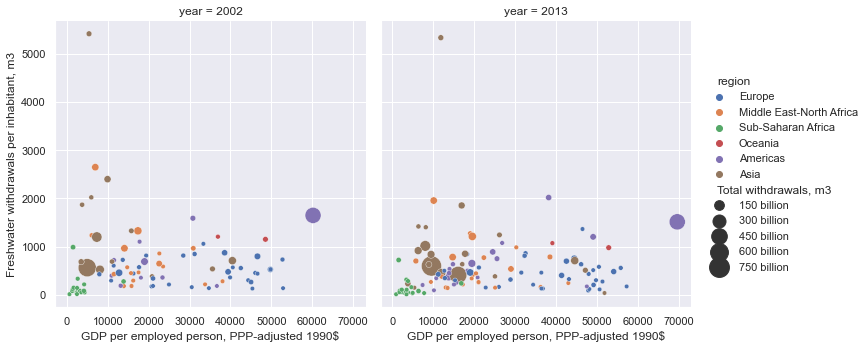

In [24]:
plot = sns.relplot(data=national_indicators, x='per_employed_gdp_ppp_1990$', y='per_capita_water_m3',
                   hue='region', size='freshwater_withdrawals_m3', sizes=(20, 400), col='year')
plot.set_xlabels('GDP per employed person, PPP-adjusted 1990$')
plot.set_ylabels('Freshwater withdrawals per inhabitant, m3')

plot._legend.texts[7].set_text('Total withdrawals, m3')
plot._legend.texts[8].set_text('150 billion')
plot._legend.texts[9].set_text('300 billion')
plot._legend.texts[10].set_text('450 billion')
plot._legend.texts[11].set_text('600 billion')
plot._legend.texts[12].set_text('750 billion')

plt.show()

Two things are evident from this plot. First, the regional information, perhaps unsurprisingly, correlates with the GDP information: virtually all sub-saharan African states (SSA) are clustered in the lower left-hand corner of the plot, whereas European nations, while somewhat spread out, are largely farther to the right. Second, there are some apparent changes that were not apparent from the earlier plot, for example an Asian country seems to have greatly increased its total withdrawals between 2002 and 2013 as there is only one large withdrawer in the former year and two in the latter year. Nevertheless, these don't change the thrust of the results.

To wrap up the analysis entirely, it would be interesting to calculate the correlation between GDP per employed person and per-capita freshwater withdrawals. Based on the above plots, I expect this value to be positive but small, as the usual Pearson's coefficient measures *linear* relationships between two variables; that is, one goes up and the other goes up. Here the relationship seems to be one of GDP going up, water withdrawals going up to a point, then leveling off or declining.

In [25]:
national_indicators.corr()

,year,freshwater_withdrawals_m3,per_employed_gdp_ppp_1990$,total_population,per_capita_water_m3
year,1.000000,0.020885,0.069322,0.047779,-0.072813
freshwater_withdrawals_m3,0.020885,1.000000,0.030824,0.910838,0.162576
per_employed_gdp_ppp_1990$,0.069322,0.030824,1.000000,-0.082229,0.025319
total_population,0.047779,0.910838,-0.082229,1.000000,0.006902
per_capita_water_m3,-0.072813,0.162576,0.025319,0.006902,1.000000


Indeed, the per_employed_gdp_pp_1990$ and per_capita_water_m3 columns have a correlation coefficient of about 0.025, indicating a very slight, indeed practically nonexistent, relationship between the two, at least in linear terms. The correlations of the various columns indeed seem to be quite weak in general, except for that between total population and total freshwater withdrawals (as might be expected).

What I conclude from this analysis is that, first, the hypothesis that per-capita water usage increases with income up to a certain point, then declines, is not ruled out by the data, and indeed appears to have some weak support. It is not possible to say that it is definitively the case from this analysis, but it appears more likely than not that something like that hypothesis is the case. The Central Asian outliers in particular seem to lend some support to this hypothesis, since the reason for their high withdrawals rates is infrastructure built during a period when they were part of a relatively richer country.

Further research would ideally start with assembling a more thorough dataset and correcting for methodological differences between countries in measuring GDP and freshwater withdrawals. Having data for more years and incorporating more countries is very important for determining how robust these results are, as well as correcting for the difficulty of directly comparing statistics between countries noted by the World Bank in the original dataset. This might also allow robust fitting of different models to the observed data, to determine what precise shape the curve linking per-capita GDP with per-capita water usage has. Another analysis of interest might be to turn to time-series information and track the movement of individual countries across the plot. This can already be done to a limited extent, for example it is clear that Chile increased in wealth and water consumption per-capita between 2002 and 2013, whereas Iraq became richer but saw its per-capita water usage decline in the same period. But if this could be extended to additional times, it might be possible to trace the movement of countries or cohorts of countries and identify the shape of the relationship curve in a completely different way.